In [1]:
import scanpy
import anndata
import matplotlib
from matplotlib import pyplot
import hdf5plugin
import numpy
import scvelo
import seaborn
import pandas
import sdevelo
import warnings
import torch

(Working on SDEvelo 0.2.12)
2026-02-17 10:02:11


In [2]:
# Check if GPU is available
print(torch.cuda.is_available())

True


In [3]:
# Suppress specific MatplotlibDeprecationWarning from the scvelo plotting module
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning) # , module="scvelo.plotting.utils"

In [4]:
# Read input file
adata = scanpy.read_h5ad("Data/clustered_anndata.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 16146 × 2104
    obs: 'leiden_0.6', 'leiden_0.2_c6', 'sample', 'latent_time'
    var: 'gene_ids', 'fit_likelihood'
    uns: 'leiden_0.2_c6_colors', 'leiden_0.6_colors', 'neighbors', 'sample_colors'
    obsm: 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'


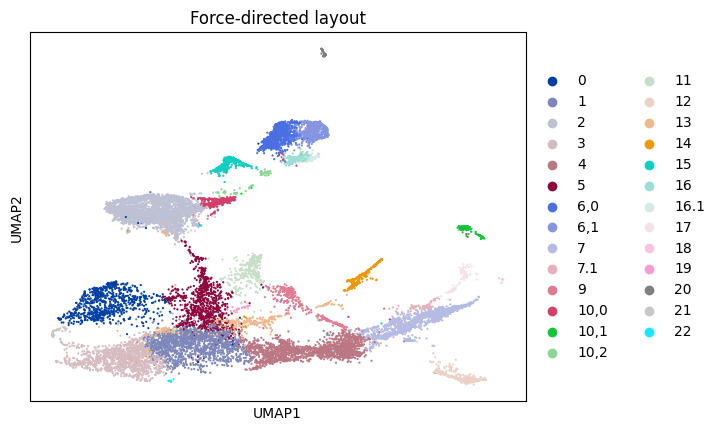

In [5]:
# Plot UMAP

scanpy.pl.embedding(basis='umap', adata=adata, color="leiden_0.2_c6", size=10, title="Force-directed layout")

In [7]:
# Define SDEvelo arguments
args = sdevelo.Config()
args.vis_key = "X_umap"
args.vis_type_col = "leiden_0.2_c6"
args.scv_n_jobs = 16
args.n_gene = 2104
args.seed = 1
args.cuda_device = 0
args.process = False # Do not redo the preprocessing

In [8]:
# Train SDEvelo model
model = sdevelo.SDENN(args, adata)
adata = model.train(600)

cuda
5000
Epoch: 0, Loss: 0.695, alpha: 0.54, beta: 2.75, gamma: 4.39, s1: 0.012, s2: 0.010,  t_m: 0.498,  u_shift: 0.000,  s_shift: 0.000
Epoch: 50, Loss: 0.510, alpha: 27.69, beta: 17.85, gamma: 62.92, s1: 0.243, s2: 0.010,  t_m: 0.184,  u_shift: 0.000,  s_shift: 0.000
Epoch: 100, Loss: 0.440, alpha: 41.30, beta: 22.49, gamma: 100.00, s1: 0.848, s2: 0.010,  t_m: 0.138,  u_shift: 0.000,  s_shift: 0.000
Epoch: 150, Loss: 0.391, alpha: 45.79, beta: 24.51, gamma: 100.00, s1: 1.200, s2: 0.010,  t_m: 0.100,  u_shift: 0.000,  s_shift: 0.000
Epoch: 200, Loss: 0.370, alpha: 49.42, beta: 25.01, gamma: 100.00, s1: 1.359, s2: 0.010,  t_m: 0.100,  u_shift: 0.000,  s_shift: 0.000
Epoch: 250, Loss: 0.373, alpha: 49.81, beta: 26.59, gamma: 100.00, s1: 1.418, s2: 0.010,  t_m: 0.100,  u_shift: 0.000,  s_shift: 0.000
Epoch: 300, Loss: 0.337, alpha: 49.90, beta: 28.41, gamma: 100.00, s1: 1.460, s2: 0.010,  t_m: 0.100,  u_shift: 0.000,  s_shift: 0.000
Epoch: 350, Loss: 0.350, alpha: 49.54, beta: 28.98, g

In [9]:
print(adata)

AnnData object with n_obs × n_vars = 16146 × 2104
    obs: 'leiden_0.6', 'leiden_0.2_c6', 'sample', 'latent_time'
    var: 'gene_ids', 'fit_likelihood', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_sigma_1', 'fit_sigma_2'
    uns: 'leiden_0.2_c6_colors', 'leiden_0.6_colors', 'neighbors', 'sample_colors'
    obsm: 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u', 'sde_velocity', 'pred_u', 'pred_s'
    obsp: 'connectivities', 'distances'


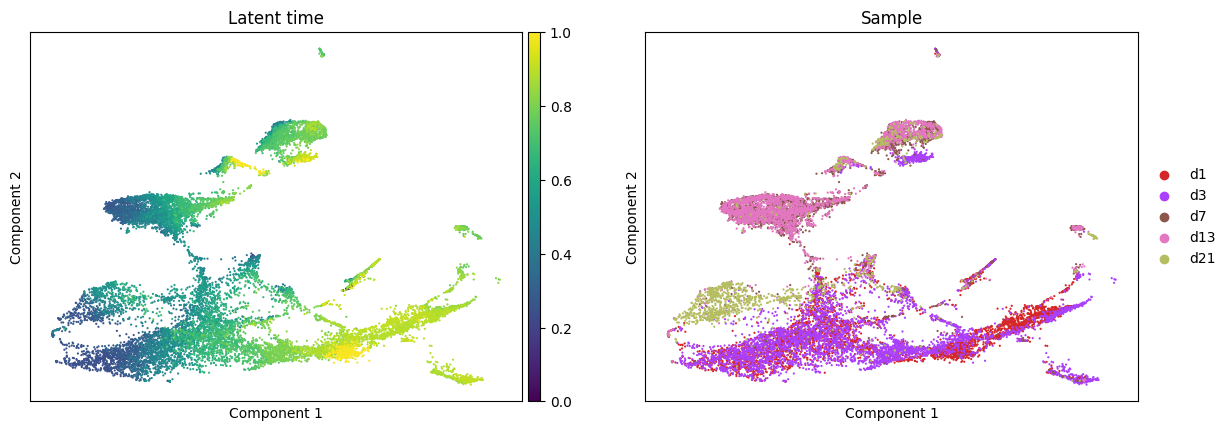

In [10]:
# Plot latent time
axis_list = scanpy.pl.embedding(basis="umap", adata=adata, color=["latent_time", "sample"], size=10, title=["Latent time", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()

In [11]:
# Velocity cosine correlations
scvelo.tl.velocity_graph(adata, vkey="sde_velocity", n_jobs=16)

computing velocity graph (using 16/16 cores)


  0%|          | 0/16146 [00:00<?, ?cells/s]

    finished (0:01:04) --> added 
    'sde_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'sde_velocity_umap', embedded velocity vectors (adata.obsm)


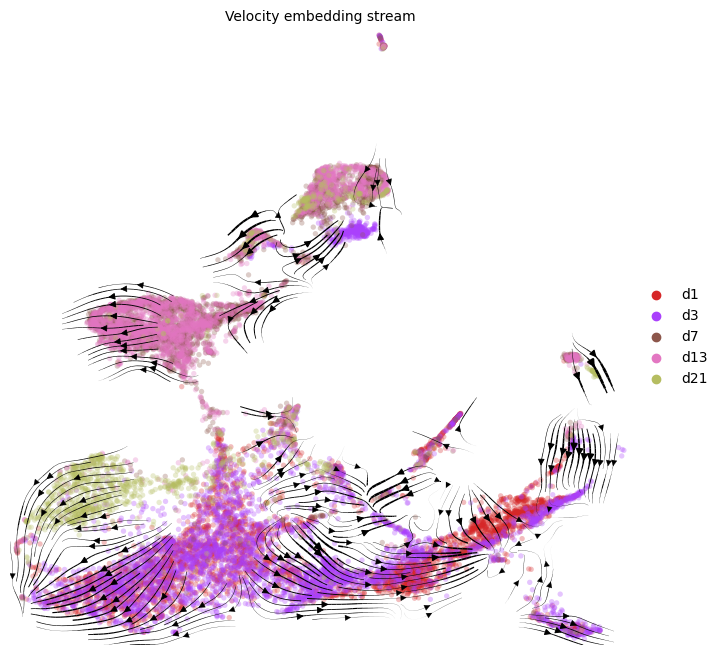

In [12]:
scvelo.pl.velocity_embedding_stream(adata, vkey="sde_velocity", basis="umap", color="sample", legend_loc="right", figsize=(8,8), title="Velocity embedding stream", density=4)

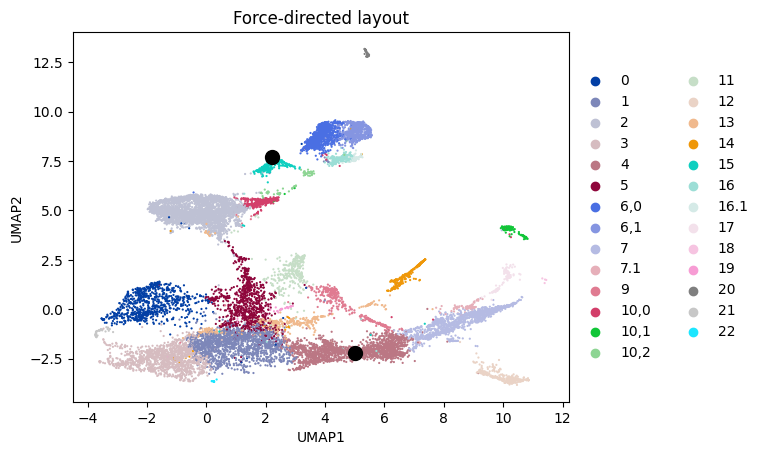

In [13]:
# Find good root and end cells

# Find root
root_filter = (adata.obs["leiden_0.2_c6"]=="4")
# Use MEF cell with largest UMAP2, ignoring outliers with >10
root_index = numpy.argmin(numpy.abs(adata[root_filter].obsm["X_umap"][:,0]-5))
root_barcode = adata[root_filter].obs.index[root_index]
adata.obs["manual_root"] = False
adata.obs["manual_root"].loc[root_barcode] = True

# Find end
end_filter = adata.obs["leiden_0.2_c6"]=="15"
# Use mESC cell with smallest UMAP1
end_index = numpy.argmax(adata[end_filter].obsm["X_umap"][:,1])
end_barcode = adata[end_filter].obs.index[end_index]
adata.obs["manual_end"] = False
adata.obs["manual_end"].loc[end_barcode] = True

ax = scanpy.pl.embedding(basis='umap', adata=adata, color="leiden_0.2_c6", size=10, title="Force-directed layout", show=False)

# Plot UMAP
ax.scatter(*adata[adata.obs["manual_end"]].obsm["X_umap"][0], marker="o", s=100, color="black")
ax.scatter(*adata[adata.obs["manual_root"]].obsm["X_umap"][0], marker="o", s=100, color="black")
ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

pyplot.show()

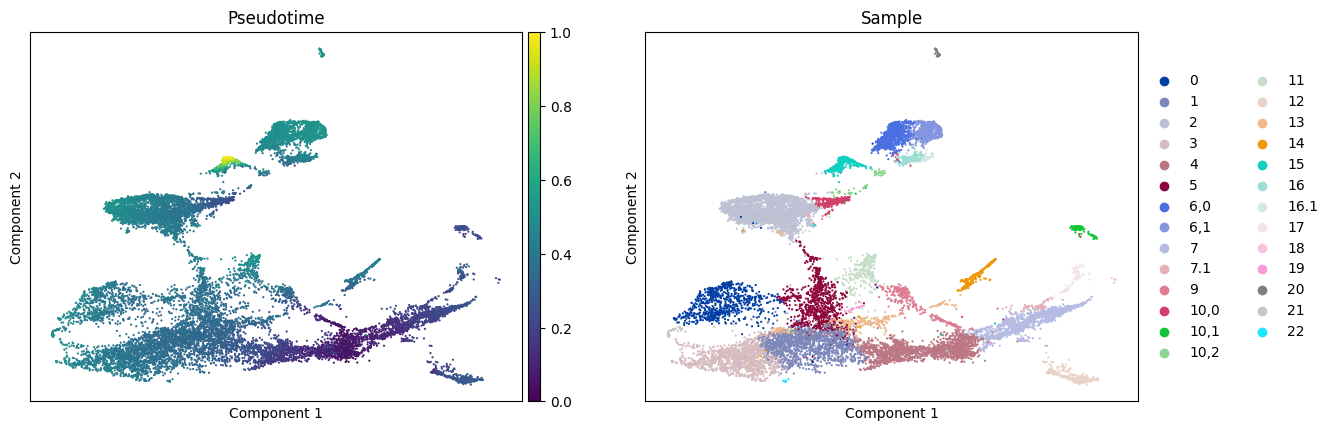

In [14]:
# Pseudotime
global_root_index = numpy.argmax(adata.obs.index == root_barcode)
global_end_index = numpy.argmax(adata.obs.index == end_barcode)

scvelo.tl.velocity_pseudotime(adata, root_key=global_root_index, end_key=global_end_index, vkey="sde_velocity")

# Plot velocities colored by latent time
axis_list = scanpy.pl.embedding(basis="umap", adata=adata, color=["sde_velocity_pseudotime", "leiden_0.2_c6"], size=10, title=["Pseudotime", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()

In [15]:
# Save adata object
adata.write_h5ad(
    "Data/pv_sdevelo_seed_1.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)